In [1]:
import pickle as pkl
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import gurobipy as gbp
%matplotlib inline

### Gerar instancias

In [2]:
def signal_strength(xe, ye, xr, yr, router):
    d = np.linalg.norm([[xe - xr], [ye - yr]])
    return router['k'] / np.square(d)

In [111]:
# area
x = 200
y = 200

# 
router_points_x = 20
router_points_y = 20

client_points_x = 20
client_points_y = 20


r_j = router_points_x * router_points_y
r_k = client_points_x * client_points_y
r_i = len(routers.keys())

grid_router = list(it.product(np.linspace(0, x-1, router_points_x, dtype=np.int), np.linspace(0, y-1, router_points_y, dtype=np.int)))
grid_clients = list(it.product(np.linspace(0, x-1, client_points_x, dtype=np.int)+1, np.linspace(0, y-1, client_points_y, dtype=np.int)+1))

# minimos
dB = -60
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]

# tipos de roteador
routers = {
    0: {'k': 10, 'c': 100},
    1: {'k': 20, 'c': 200},
    2: {'k': 30, 'c': 300},
    3: {'k': 40, 'c': 400},
    4: {'k': 50, 'c': 500},
    5: {'k': 60, 'c': 600}
}

instancia0 = {
    'router_types': router,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak
}

# minimos
dB = -20
Ak = [10 ** (dB/20) for i in range(len(grid_clients))]
instancia = {
    'router_types': router,
    'router_spots': grid_router,
    'client_spots': grid_clients,
    'client_min_sig': Ak
}


In [91]:
update = True

In [92]:
%%time
if update:
    Sijk = np.array([[[signal_strength(xe, ye, xr, yr, router) if (xe != xr) & (ye != yr) else 1 for xr, yr in grid_clients] for xe, ye in grid_router] for n, router in routers.items()])
    pkl.dump(Sijk, open("Sijk.p", "wb" ))
    update = False
else:
    Sijk = pkl.load(open("Sijk.p", "rb" ))

CPU times: user 1min, sys: 725 ms, total: 1min 1s
Wall time: 1min 1s


### Criar modelo no Gurobi

In [112]:
%%time
m = gbp.Model("Alocação de roteadores")

# variaveis
Xij = np.array([[m.addVar(vtype=gbp.GRB.BINARY, name="X %d,%d" % (i, j)) for j in range(r_j)] for i in range(r_i)])

# função objetivo
Ci = [r['c'] for r in routers.values()]

obj = gbp.LinExpr()
for j in range(r_j): 
    for i in range(r_i): 
        obj += Ci[i] * Xij[i, j]
m.setObjective(obj, gbp.GRB.MINIMIZE)

## restrições
# maximo 1 roteador por ponto no grid
for j in range(r_j):
    rest = gbp.LinExpr()
    for i in range(r_i): rest += Xij[i, j]
    m.addConstr(rest <= 1, "r %d" % j)


# restrição de sinal
for k in range(r_k): 
    rest = gbp.LinExpr()
    for i in range(r_i): 
        for j in range(r_j):
            rest += Xij[i, j] * Sijk[i, j, k]
    m.addConstr(rest >= Ak[k], "s %d" % k)

CPU times: user 10.3 s, sys: 105 ms, total: 10.4 s
Wall time: 11.2 s


In [ ]:
m.optimize()

for v in m.getVars():
    if v.x: print(v.varName, v.x)

print('Obj:', m.objVal)

Optimize a model with 800 rows, 2400 columns and 962400 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+01]
  Objective range  [1e+02, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 1e+00]
Found heuristic solution: objective 13400.000000
Presolve time: 2.50s
Presolved: 800 rows, 2400 columns, 962400 nonzeros
Variable types: 0 continuous, 2400 integer (2400 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     686    3.0134289e+03   1.530586e+01   0.000000e+00      5s
     994    3.0226262e+03   0.000000e+00   0.000000e+00      7s

Root relaxation: objective 3.022626e+03, 994 iterations, 3.84 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3022.62618    0  297 13400.0000 3022.62618  77.4%     -    7s
H    0     0                

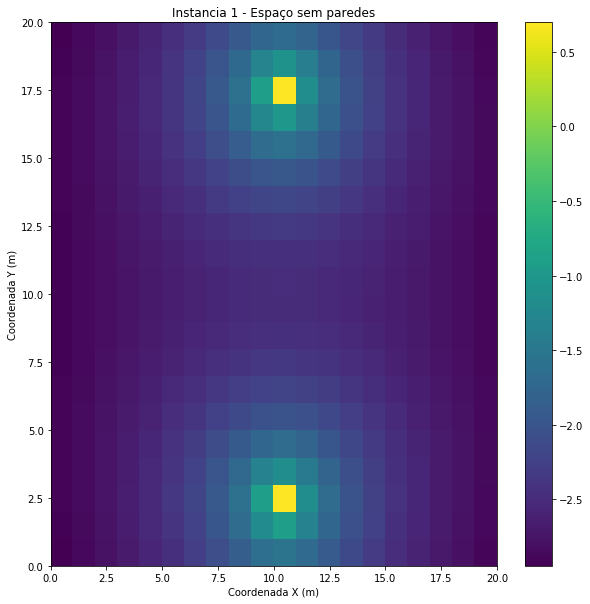

In [110]:
Rij = np.array([v.x for v in m.getVars()]).reshape((r_i, r_j))

potencia = np.array([np.log10(np.sum([Rij[i, j] * Sijk[i, j, k] for j in range(r_j) for i in range(r_i)])) for k in range(r_k)]).reshape(client_points_x, client_points_y)

fig, ax = plt.subplots(figsize=(10,10))
c = ax.pcolor(potencia)
fig.colorbar(c, ax=ax)
ax.set_title('Instancia 1 - Espaço sem paredes')
ax.set_xlabel('Coordenada X (m)')
ax.set_ylabel('Coordenada Y (m)');